# __Sentiment Analysis on Womens Clothing E-Commerce Reviews__
> 1. Train and Test several models on the dataset 'Womens Clothing E-Commerce Reviews.csv'
> > + Fully Connected Neural Network (FCNN)
> > + Recurrent Neural Network (RNN)
> 2. Predict the sentiment on 'chatbots-virtual-assistant-Bitext-sample.csv'

## __Phase 1: Training and Test__

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load the dataset

In [5]:
women_df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
women_df.drop('Unnamed: 0', axis = 1, inplace = True)     # drop some column
women_df.dropna(inplace = True)     # modify in the original data
women_df.reset_index(drop = True, inplace = True)     # reset index after dropna
women_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


In [6]:
women_df['Rating'].value_counts()

5    10858
4     4289
3     2464
2     1360
1      691
Name: Rating, dtype: int64

<AxesSubplot:xlabel='Rating', ylabel='count'>

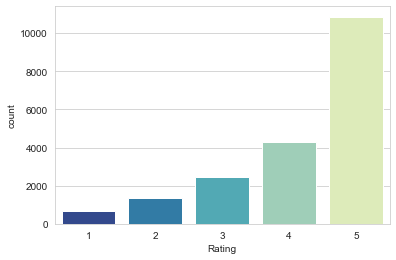

In [7]:
sns.set_style('whitegrid')
sns.countplot(x = 'Rating',data = women_df, palette = 'YlGnBu_r')

#### The Rating is unevenly distributed. Rating = 5 has the largest count number, and is almost equal to the sum of the counts of other levels.

### Calculate Polarity Rating based on the rating
> + Apply the following rules:
> + the existing rating > 3, then polarity_rating = 'Positive'
> + the existing rating == 3, then polarity_rating = 'Neutral'
> + the existing rating < 3, then polarity_rating = 'Negative'

In [8]:
women_df['Polarity_Rating'] = women_df['Rating'].apply(
    lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative')
)
women_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Polarity_Rating
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Neutral
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,Positive
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Positive
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,Negative
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,Positive


In [9]:
women_df['Polarity_Rating'].value_counts()

Positive    15147
Neutral      2464
Negative     2051
Name: Polarity_Rating, dtype: int64

<AxesSubplot:xlabel='Polarity_Rating', ylabel='count'>

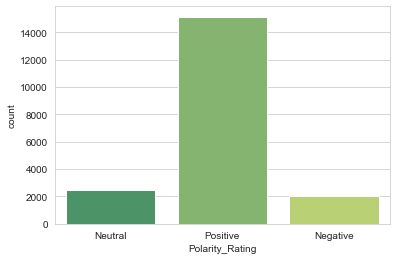

In [10]:
sns.set_style('whitegrid')
sns.countplot(x = 'Polarity_Rating', data = women_df, palette = 'summer')

#### The distribution of Polarity Rating is extremely imbalanced. Positive has the far most count number than other two levels.

### Resampling
> to make Polarity Rating is equally distributed, in which each level has 8,000 data samples

In [11]:
# Positive has data samples > 8000
# so we sample 8000 from all samples without replacement, whichs no repetition
# by default replace = False, means sample without replacement
df_Positive = women_df[women_df['Polarity_Rating'] == 'Positive'].sample(
    n = 8000, replace = False, random_state = 1
)
df_Neutral = women_df[women_df['Polarity_Rating'] == 'Neutral']
df_Negative = women_df[women_df['Polarity_Rating'] == 'Negative']

In [12]:
# Neutral, Negative has samples < 8000
# so we sample them to 8000 with replacement, which have repetitions
# replace = True, means sample with replacement
df_Neutral_over = df_Neutral.sample(8000, replace = True, random_state = 1)
df_Negative_over = df_Negative.sample(8000, replace = True, random_state = 1)
women_sample_df = pd.concat([df_Positive, df_Neutral_over, df_Negative_over], axis = 0)
# reset index after resampling
women_sample_df.reset_index(drop = True, inplace = True)
women_sample_df.shape

(24000, 11)

### TextToText Preprocessing on 'Review Text'

In [13]:
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daikeig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/daikeig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
stopwords = stopwords.words("english")

def processTextToText(tweet):

    # convert all words in the tweet into the lower case
    tweet = tweet.lower()

    # remove the urls
    tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                             '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', tweet)
    # remove the @ and references
    tweet = re.sub(r"(@[A-Za-z0-9_]+)","", tweet)
    # remove special charaecters
    tweet = re.sub(r'[\#\:\)\n\/\_\-\&]','', tweet)

    # tokenize the string into list of words
    word_list = word_tokenize(tweet)
    
    # filter out the stop words and punctuations in the list
    word_list = [w for w in word_list if (not w in stopwords) and (w.isalpha())]

    # transfer all remained words into the word stems i.e., perform stemming
    porter = PorterStemmer()
    word_list = [porter.stem(w) for w in word_list]

    return ' '.join(word_list)

In [15]:
from tqdm import tqdm

In [16]:
women_processed = []
for i in tqdm(range(women_sample_df.shape[0])):
    women_processed.append(processTextToText(women_sample_df.iloc[i, 3]))     # Review Text

100%|███████████████████████████████████| 24000/24000 [00:15<00:00, 1558.21it/s]


In [17]:
women_sample_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Polarity_Rating
0,1095,21,All-season perfection,I bought this dress after eyeing it up for wee...,5,1,0,General,Dresses,Dresses,Positive
1,877,48,Cute shirt,I agree with the other reviewers. this shirt i...,5,1,1,General,Tops,Knits,Positive
2,1044,33,Poofy,"I wish these fit more like joggers, but they a...",4,1,1,General Petite,Bottoms,Pants,Positive
3,1062,42,Perfect summer staple,This is my first romper and i am in love. so ...,5,1,3,General,Bottoms,Pants,Positive
4,1150,67,This is a keeper,"I just got this dress in the mail, and i have ...",5,1,16,General,Dresses,Dresses,Positive


### Visualize the Preprocessed Review Text

In [18]:
for i in range(5):
    print(women_processed[i], '\n')

bought dress eye week realli stun red incred vibrant especi linen construct highqual sinc linen feel crisp light layer nice pullov roll sleev flatout hot day rayon slip realli nice touch sinc linen fairli transpar realli drove home sens qualiti bought mine size found slightli big 

agre review shirt cuter person flatter cut design even prettier photo color navynot charcoal color look photo stitch also color real life 

wish fit like jogger slightli poofier big button felt bit clownish howev great statement piec qualiti good fabric nice textur think problem sinc linen drape scrunch like less structur fabric hold volum instead loos semiflowi menswear look 

first romper love comfort easili dress usual xs small petit small retail brand xs work best petit small big length xs perfect ankl length nervou put washer delic cycl came perfectli 

got dress mail disagre previou review embroideri dress well done thick materi high qualiti although breathabl hold perfectli embroideri usual order extr

### Apply One-hot Encoding to the Response Variable Polarity_Rating

In [19]:
y = pd.get_dummies(women_sample_df['Polarity_Rating'])
y.head()

,Negative,Neutral,Positive
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


### Apply train_test_split

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(women_processed, y, test_size = 0.3, random_state = 8307)

print(y_train.value_counts(), '\n')
print(y_test.value_counts(), '\n')
print(X_test[0:5])

Negative  Neutral  Positive
0         1        0           5612
          0        1           5601
1         0        0           5587
dtype: int64 

Negative  Neutral  Positive
1         0        0           2413
0         0        1           2399
          1        0           2388
dtype: int64 

['order top onlin love color design listen review order usual size unflatt short wide like pictur model needless say immedi ship back', 'maev great materi vivid color amaz fit tri dress week ago purchas saw sale could get store quick enough ladi bottom heavi like dress make look awesom', 'origin purchas dress petit bust petit bit tight return went size happi dress drape flow beauti find immens flatter hourglass figur also ador floral print one review object way bodic drape small hook closur seem insuffici object characterist fit beauti throughout bodic', 'absolut gorgeou poorli fit blous bottom part way billowi inconsist fit top half got sale still return', 'color darker shown order denim 

### Apply Vectorization

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X_train_vec = vect.fit_transform(X_train)
X_test_vec = vect.transform(X_test)

### Apply Frequency, Inverse Document Frequency

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X_train_vec = tfidf.fit_transform(X_train_vec)
X_test_vec = tfidf.transform(X_test_vec)
X_train_vec = X_train_vec.toarray()
X_test_vec = X_test_vec.toarray()

In [23]:
X_test_vec[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## ***Model 1: Fully Connected Neural Network (FCNN)***

### Build Model 1 with Deep Learning

In [24]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

### Add Different Layers to Model 1

In [25]:
tf.keras.backend.clear_session()

model_1 = Sequential()

model_1.add(Dense(units = 12673, activation = "relu"))
model_1.add(Dropout(0.5))

model_1.add(Dense(units = 4000, activation = "relu"))
model_1.add(Dropout(0.5))

model_1.add(Dense(units = 500, activation = "relu"))
model_1.add(Dropout(0.5))

model_1.add(Dense(units  =3, activation = "softmax"))

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

model_1.compile(optimizer = opt,loss = "categorical_crossentropy", metrics = ["accuracy"])

early_stop = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 2)

Metal device set to: Apple M1


2022-08-06 14:50:01.197739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-06 14:50:01.197940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Fit the Model 1

In [26]:
model_1.fit(
    x = X_train_vec,
    y = y_train,
    batch_size = 256,
    epochs = 30,
    validation_data = (X_test_vec, y_test),
    verbose = 1,
    callbacks = early_stop,
)

Epoch 1/30


2022-08-06 14:50:02.103260: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-06 14:50:02.918653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.7094

2022-08-06 14:50:23.371668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 23s 328ms/step - loss: 0.6436 - accuracy: 0.7094 - val_loss: 0.3358 - val_accuracy: 0.8726
Epoch 2/30
66/66 [==============================] - 21s 322ms/step - loss: 0.1291 - accuracy: 0.9568 - val_loss: 0.2298 - val_accuracy: 0.9283
Epoch 3/30
 9/66 [===>..........................] - ETA: 17s - loss: 0.0260 - accuracy: 0.9935

KeyboardInterrupt: 

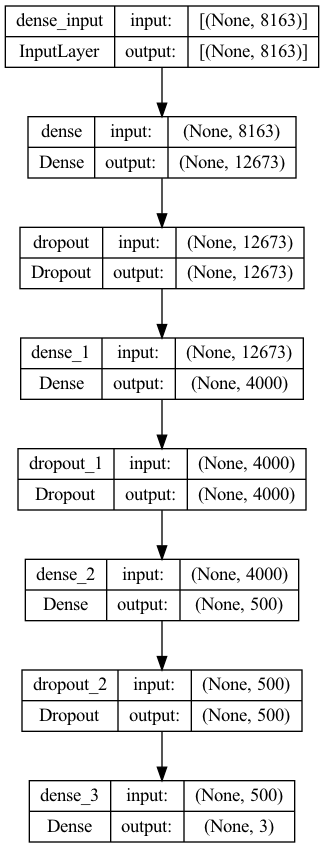

In [27]:
from keras.utils.vis_utils import plot_model
plot_model(model_1, './model_1.png', show_shapes = True)

### Evaluation of Model 1

In [28]:
model_1_score = model_1.evaluate(X_test_vec, y_test, batch_size = 64, verbose = 1)
print("Test Accuracy:", model_1_score[1])

113/113 [==============================] - 3s 21ms/step - loss: 0.2519 - accuracy: 0.9260
Test Accuracy: 0.9259722232818604


### Save Model 1

In [29]:
!mkdir -p saved_model
model_1.save('./saved_model/FCNN')

INFO:tensorflow:Assets written to: ./saved_model/FCNN/assets


### Prediction of X_test by Model 1

In [ ]:
model_1_pred = model_1.predict(X_test_vec)
model_1_pred[0:5, :]

In [ ]:
y_test_sentiment = []
for line in y_test.values:
    sc = np.argmax(line)
    if sc == 0:
        y_test_sentiment.append('Negative')
    elif sc == 1:
        y_test_sentiment.append('Neutral')
    elif sc == 2:
        y_test_sentiment.append('Positive')
y_test_sentiment[0:5]

In [ ]:
model_1_sentiment = []
for line in  model_1_pred:
    sc = np.argmax(line)
    if sc == 0:
        model_1_sentiment.append('Negative')
    elif sc == 1:
        model_1_sentiment.append('Neutral')
    elif sc == 2:
        model_1_sentiment.append('Positive')
model_1_sentiment[0:5]

In [ ]:
model_1_info = pd.DataFrame()
model_1_info['Preprocessed Review Text'] = X_test
model_1_info['True Sentiment'] = y_test_sentiment
model_1_info['FCNN Sentiment'] = model_1_sentiment
model_1_info

## ***Model 2: Recurrent Neural Network (RNN)***

### Word Embedding

In [ ]:
women_sample_df.head()

In [ ]:
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [ ]:
# define the stop words
stopwords = stopwords.words("english")

def processTextToToken(tweet):

    # convert all words in the tweet into the lower case
    tweet = tweet.lower()

    # remove the urls
    tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                             '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', tweet)
    # remove the @ and references
    tweet = re.sub(r"(@[A-Za-z0-9_]+)","", tweet)
    # remove special charaecters
    tweet = re.sub(r'[\#\:\)\n\/\_\-\&]','', tweet)

    # tokenize the string into list of words
    word_list = word_tokenize(tweet)
    
    # filter out the stop words and punctuations in the list
    word_list = [w for w in word_list if (not w in stopwords) and (w.isalpha())]

    # transfer all remained words into the word stems i.e., perform stemming
    porter = PorterStemmer()
    word_list = [porter.stem(w) for w in word_list]

    return word_list

In [ ]:
from tqdm import tqdm

In [ ]:
women_token = []
for i in tqdm(range(women_sample_df.shape[0])):
    women_token.append(processTextToToken(women_sample_df.iloc[i, 3]))

In [ ]:
for i in range(5):
    print(women_token[i], '\n')

In [ ]:
y = pd.get_dummies(women_sample_df['Polarity_Rating'])
y.head()

In [ ]:
from sklearn.model_selection import train_test_split

# y is the previous one-hot encoding
Token_train, Token_test, y_train, y_test = train_test_split(women_token, y, test_size = 0.3, random_state = 8307)

print(y_train.value_counts(), '\n')
print(y_test.value_counts(), '\n')
print(Token_test[0:5])

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Train the Word2Vec model obtained from gensim over the processed training Token data
# (using the default parameters of Word2Vec)
model_word2vec = Word2Vec(Token_train)

In [ ]:
# report the size of vocabulary for the trained word2vec model
size_vocab = len(model_word2vec.wv.key_to_index)
print('The Size of The Vocabulary:', size_vocab)

In [ ]:
# save the word vectors into a local file named as 'embedding_word2vec.txt'
word_vectors = model_word2vec.wv
word_vectors.save_word2vec_format('embedding_word2vec.txt', binary = False)

In [ ]:
# load the saved embeddings from the disk
# create a embedding dictionary with the key as the word and the value as the corresponding numerical embedding vector
from gensim.models import KeyedVectors
embedding_dict = {}

f = open('embedding_word2vec.txt', 'r')
word_dim = f.readline().strip('\n').split(' ')     # skip first line '3646 100\n'
n_word = int(word_dim[0])
n_dim = int(word_dim[1])
for line in f:
    key_value = line.strip('\n').split(' ')
    embedding_dict[key_value[0]] = key_value[1:]
f.close()

if len(embedding_dict) == n_word:
    print('The Shape of The Embedding Dictionary:', (n_word, n_dim))

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# define a Tokenizer() from tensorflow.keras.preprocessing.text, and fit it on the processed training Token data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Token_train)

In [ ]:
# obtain the word index (a dictionary object with the format as {word:index}, and the index starts from 1)
# initialize a zero embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index)+1, n_dim))

In [ ]:
# iterate over the word index dictionary
for k, v in word_index.items():
    if embedding_dict.get(k) is not None:
        embedding_matrix[v] = embedding_dict.get(k)
        
# report the shape of the embedding matrix
print('The Shape of The Embedding Matrix:', embedding_matrix.shape)

In [ ]:
embedding_matrix

In [ ]:
# transfer the processed training texts into a list of index sequences
# using the aforementioned fitted tokenizer
train_sequences = tokenizer.texts_to_sequences(Token_train)
print(train_sequences[0:5])

In [ ]:
# find the maximum length of the training sequences within the list
train_max_len = -1
for seq in train_sequences:
    if len(seq) >= train_max_len:
        train_max_len = len(seq)
print('The Maximum ength of The Training Sequences:', train_max_len)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# use pad_sequences to pad the list of training sequences with the length of each sequence as the maximum length
X_train = pad_sequences(train_sequences, maxlen = train_max_len, padding = 'post')
X_train

In [ ]:
# generate X_test based on the same tokenizer fitted over the training texts
test_sequences = tokenizer.texts_to_sequences(Token_test)
print(test_sequences[0:5])

In [ ]:
# generate X_test based on the same tokenizer fitted over the training texts
# note: the padding length for the test data is identical to the maximum length of the training data
X_test = pad_sequences(test_sequences, maxlen = train_max_len, padding = 'post')
X_test

In [ ]:
# report the shapes of X_train,y_train, X_test andy_test
print('The Shape of X_train:', X_train.shape)
print('The Shape of y_train:', y_train.shape)
print('The Shape of X_test:', X_test.shape)
print('The Shape of y_test:', y_test.shape)

### Build Model 2 with RNN

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense

In [ ]:
# define a word2vec embedding layer based on the embedding matrix via Keras
word2vec_embedding = Embedding(input_dim = embedding_matrix.shape[0],
                               output_dim = embedding_matrix.shape[1],
                               input_length = train_max_len,
                               weights = [embedding_matrix],
                               trainable = False)

### Add Different Layers to Model 2

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional, GRU
from keras.callbacks import EarlyStopping

In [ ]:
# define the RNN model
model_2 = Sequential()

# Embedding layer
model_2.add(word2vec_embedding)

# GRU Layer
model_2.add(GRU(1024, dropout = 0.5, return_sequences = True))

# GRU Layer
model_2.add(Bidirectional(GRU(128, dropout = 0.3)))
# model_2.add(GRU(64, dropout = 0.1))

# Output Dense layer
model_2.add(Dense(y_train.shape[1], activation = 'softmax'))

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

model_2.compile(optimizer = opt,loss = "categorical_crossentropy", metrics = ["accuracy"])

early_stop = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 2)

# Report the model structure 
model_2.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_2, './model_2.png', show_shapes = True)

### Fit the Model 2

In [ ]:
# train the model
model_2.fit(X_train, y_train,
            batch_size = 256,
            epochs = 100,
            validation_data = (X_test, y_test),
            verbose = 1,
            callbacks = early_stop)

### Evaluation of Model 2

In [ ]:
# report the accuracy scores for the training and test set
model_2_train_acc = model_2.evaluate(X_train, y_train)[1]     # [loss, acc]
model_2_test_acc = model_2.evaluate(X_test, y_test)[1]
print('The Accuracy Score for The Training Set:', model_2_train_acc)
print('The Accuracy Score for The Test Set:', model_2_test_acc)

### Save Model 2

In [ ]:
!mkdir -p saved_model
model_2.save('./saved_model/RNN')

### Prediction of X_test by Model 2

In [ ]:
y_test_sentiment = []
for line in y_test.values:
    sc = np.argmax(line)
    if sc == 0:
        y_test_sentiment.append('Negative')
    elif sc == 1:
        y_test_sentiment.append('Neutral')
    elif sc == 2:
        y_test_sentiment.append('Positive')
y_test_sentiment[0:5]

In [ ]:
# make sentiment predictions on those collected data, here X_test
model_2_pred = model_2.predict(X_test)
model_2_pred

In [ ]:
# make sentiment predictions on those collected data, here X_test
model_2_sentiment = []
for line in  model_2_pred:
    sc = np.argmax(line)
    if sc == 0:
        model_2_sentiment.append('Negative')
    elif sc == 1:
        model_2_sentiment.append('Neutral')
    elif sc == 2:
        model_2_sentiment.append('Positive')
model_2_sentiment[0:5]

In [ ]:
# for each tweet, show the sentiment scores (predicted probability) together with the text
model_2_info = pd.DataFrame()
model_2_info['Review Token'] = Token_test
model_2_info['True Sentiment'] = y_test_sentiment
model_2_info['RNN Sentiment'] = model_2_sentiment
model_2_info

In [ ]:
women_info = pd.DataFrame()
women_info['Preprocessed Review Text'] = model_1_info['Preprocessed Review Text']
women_info['Review Token'] = model_2_info['Review Token']
women_info['True Sentiment'] =  y_test_sentiment
women_info['FCNN Sentiment'] = model_1_sentiment
women_info['RNN Sentiment'] = model_2_sentiment
women_info

In [ ]:
women_info.to_csv('women_info.csv', index = False)

## __Phase 2: Prediction__
> 1. Predict the sentiment on 'chatbots-virtual-assistant-Bitext-sample.csv'   
> 2. Use the Model 2: Recurrent Neural Network (RNN)

In [31]:
chat_path = '../content/archive/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample' + \
'/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample' + \
'/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv'

chat_df = pd.read_csv(chat_path)
chat_df.head()

,flags,utterance,category,intent
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account
4,BLQC,"i want an online account, create one",ACCOUNT,create_account


In [ ]:
chat_processed = []
for i in tqdm(range(chat_df.shape[0])):
    chat_processed .append(processTextToToken(chat_df.iloc[i, 1])) # utterance

In [ ]:
for i in range(5):
    print(chat_processed[i], '\n')

In [ ]:
chat_sequences = tokenizer.texts_to_sequences(chat_processed)
chat_X = pad_sequences(chat_sequences, maxlen = train_max_len, padding = 'post')
chat_X

In [ ]:
# make sentiment predictions on those collected data
chat_y = model_2.predict(chat_X) # RNN
chat_y

In [ ]:
# make sentiment predictions on those collected data
chat_sentiment = []
for line in  chat_y:
    sc = np.argmax(line)
    if sc == 0:
        chat_sentiment.append('Negative')
    elif sc == 1:
        chat_sentiment.append('Neutral')
    elif sc == 2:
        chat_sentiment.append('Positive')
chat_sentiment[0:5]

In [ ]:
chat_info = pd.DataFrame()
chat_info['utterance'] = chat_df['utterance']
chat_info['Utterance Token'] = chat_processed
chat_info['RNN Sentiment'] = chat_sentiment
chat_info

In [ ]:
chat_info['RNN Sentiment'].value_counts()

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x = 'RNN Sentiment', data = chat_info, palette = 'summer')

In [ ]:
chat_info.to_csv('chat_info.csv', index = False)

# __Rating Analysis on Womens Clothing E-Commerce Reviews__
> 1. Train and Test some model on the dataset 'Womens Clothing E-Commerce Reviews.csv'
> > + Recurrent Neural Network (RNN)
> 2. Predict the rating on 'chatbots-virtual-assistant-Bitext-sample.csv'
> 3. It is better to restart the kernel to run the Rating Analysis.

## __Phase 1: Training and Test__

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load the dataset

In [32]:
women_df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
women_df.drop('Unnamed: 0', axis = 1, inplace = True)     # drop some column
women_df.dropna(inplace = True)     # modify in the original data
women_df.reset_index(drop = True, inplace = True)     # reset index after dropna
women_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


In [ ]:
women_df['Rating'].value_counts()

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x = 'Rating',data = women_df, palette = 'YlGnBu_r')

#### The Rating is unevenly distributed. Rating = 5 has the largest count number, and is almost equal to the sum of the counts of other levels.¶

### Resampling
> to make Rating is equally distributed, in which each level has 8,000 data samples

In [ ]:
# Level=5 has data samples > 8000
# so we sample 8000 from all samples without replacement, whichs no repetition
# by default replace = False, means sample without replacement
df_l5 = women_df[women_df['Rating'] == 5].sample(
    n = 8000, replace = False, random_state = 1
)
df_l1 = women_df[women_df['Rating'] == 1]
df_l2 = women_df[women_df['Rating'] == 2]
df_l3 = women_df[women_df['Rating'] == 3]
df_l4 = women_df[women_df['Rating'] == 4]

In [ ]:
# Level=1, 2, 3, 4 has samples < 8000
# so we sample them to 8000 with replacement, which have repetitions
# replace = True, means sample with replacement
df_l1_over = df_l1.sample(8000, replace = True, random_state = 1)
df_l2_over = df_l2.sample(8000, replace = True, random_state = 1)
df_l3_over = df_l3.sample(8000, replace = True, random_state = 1)
df_l4_over = df_l4.sample(8000, replace = True, random_state = 1)
women_sample_df = pd.concat([df_l5, df_l1_over, df_l2_over, df_l3_over, df_l4_over], axis = 0)
# reset index after resampling
women_sample_df.reset_index(drop = True, inplace = True)
women_sample_df.shape

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x = 'Rating',data = women_sample_df, palette = 'YlGnBu_r')

### Word Embedding

In [ ]:
women_sample_df.head()

In [ ]:
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [ ]:
# define the stop words
stopwords = stopwords.words("english")

def processTextToToken(tweet):

    # convert all words in the tweet into the lower case
    tweet = tweet.lower()

    # remove the urls
    tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                             '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', tweet)
    # remove the @ and references
    tweet = re.sub(r"(@[A-Za-z0-9_]+)","", tweet)
    # remove special charaecters
    tweet = re.sub(r'[\#\:\)\n\/\_\-\&]','', tweet)

    # tokenize the string into list of words
    word_list = word_tokenize(tweet)
    
    # filter out the stop words and punctuations in the list
    word_list = [w for w in word_list if (not w in stopwords) and (w.isalpha())]

    # transfer all remained words into the word stems i.e., perform stemming
    porter = PorterStemmer()
    word_list = [porter.stem(w) for w in word_list]

    return word_list

In [ ]:
from tqdm import tqdm

In [ ]:
women_token = []
for i in tqdm(range(women_sample_df.shape[0])):
    women_token.append(processTextToToken(women_sample_df.iloc[i, 3]))

In [ ]:
for i in range(5):
    print(women_token[i], '\n')

In [ ]:
y = pd.get_dummies(women_sample_df['Rating'])
y.head()

In [ ]:
from sklearn.model_selection import train_test_split

# y is the previous one-hot encoding
Token_train, Token_test, y_train, y_test = train_test_split(women_token, y, test_size = 0.3, random_state = 8307)

print(y_train.value_counts(), '\n')
print(y_test.value_counts(), '\n')
print(Token_test[0:5])

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Train the Word2Vec model obtained from gensim over the processed training Token data
# (using the default parameters of Word2Vec)
model_word2vec = Word2Vec(Token_train)

In [ ]:
# report the size of vocabulary for the trained word2vec model
size_vocab = len(model_word2vec.wv.key_to_index)
print('The Size of The Vocabulary:', size_vocab)

In [ ]:
# save the word vectors into a local file named as 'new_embedding_word2vec.txt'
word_vectors = model_word2vec.wv
word_vectors.save_word2vec_format('new_embedding_word2vec.txt', binary = False)

In [ ]:
# load the saved embeddings from the disk
# create a embedding dictionary with the key as the word and the value as the corresponding numerical embedding vector
from gensim.models import KeyedVectors
embedding_dict = {}

f = open('new_embedding_word2vec.txt', 'r')
word_dim = f.readline().strip('\n').split(' ')     # skip first line '3646 100\n'
n_word = int(word_dim[0])
n_dim = int(word_dim[1])
for line in f:
    key_value = line.strip('\n').split(' ')
    embedding_dict[key_value[0]] = key_value[1:]
f.close()

if len(embedding_dict) == n_word:
    print('The Shape of The Embedding Dictionary:', (n_word, n_dim))

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# define a Tokenizer() from tensorflow.keras.preprocessing.text, and fit it on the processed training Token data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Token_train)

In [ ]:
# obtain the word index (a dictionary object with the format as {word:index}, and the index starts from 1)
# initialize a zero embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index)+1, n_dim))

In [ ]:
# iterate over the word index dictionary
for k, v in word_index.items():
    if embedding_dict.get(k) is not None:
        embedding_matrix[v] = embedding_dict.get(k)
        
# report the shape of the embedding matrix
print('The Shape of The Embedding Matrix:', embedding_matrix.shape)

In [ ]:
embedding_matrix

In [ ]:
# transfer the processed training texts into a list of index sequences
# using the aforementioned fitted tokenizer
train_sequences = tokenizer.texts_to_sequences(Token_train)
print(train_sequences[0:5])

In [ ]:
# find the maximum length of the training sequences within the list
train_max_len = -1
for seq in train_sequences:
    if len(seq) >= train_max_len:
        train_max_len = len(seq)
print('The Maximum ength of The Training Sequences:', train_max_len)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# use pad_sequences to pad the list of training sequences with the length of each sequence as the maximum length
X_train = pad_sequences(train_sequences, maxlen = train_max_len, padding = 'post')
X_train

In [ ]:
# generate X_test based on the same tokenizer fitted over the training texts
test_sequences = tokenizer.texts_to_sequences(Token_test)
print(test_sequences[0:5])

In [ ]:
# generate X_test based on the same tokenizer fitted over the training texts
# note: the padding length for the test data is identical to the maximum length of the training data
X_test = pad_sequences(test_sequences, maxlen = train_max_len, padding = 'post')
X_test

In [ ]:
# report the shapes of X_train,y_train, X_test andy_test
print('The Shape of X_train:', X_train.shape)
print('The Shape of y_train:', y_train.shape)
print('The Shape of X_test:', X_test.shape)
print('The Shape of y_test:', y_test.shape)

### Build Model 3 with RNN

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, LSTM

In [ ]:
# define a word2vec embedding layer based on the embedding matrix via Keras
word2vec_embedding = Embedding(input_dim = embedding_matrix.shape[0],
                               output_dim = embedding_matrix.shape[1],
                               input_length = train_max_len,
                               weights = [embedding_matrix],
                               trainable = False)

### Add Different Layers to Model 3

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional, GRU
from keras.callbacks import EarlyStopping

In [ ]:
# define the RNN model
model_3 = Sequential()

# Embedding layer
model_3.add(word2vec_embedding)

# GRU Layer
model_3.add(GRU(1024, dropout = 0.5, return_sequences = True))

# GRU Layer
model_3.add(Bidirectional(GRU(256, dropout = 0.5)))
# model_2.add(GRU(64, dropout = 0.1))

# Output Dense layer
model_3.add(Dense(y_train.shape[1], activation = 'softmax'))

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

model_3.compile(optimizer = opt,loss = "categorical_crossentropy", metrics = ["accuracy"])

early_stop = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 2)

# Report the model structure 
model_3.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_3, './model_3.png', show_shapes = True)

### Fit the Model 3

In [ ]:
# train the model
model_3.fit(X_train, y_train,
            batch_size = 256,
            epochs = 100,
            validation_data = (X_test, y_test),
            verbose = 1,
            callbacks = early_stop)

### Or Load the Pre-trained Model 3
> I add this block since after the first time I fitted the model 3, I cleared the cache. Therefore, I need to load the model to generated the dataset I want, instead of refitting the model 3.

In [ ]:
model_3 = keras.models.load_model('./saved_model/RNN2')

### Evaluation of Model 3

In [ ]:
# report the accuracy scores for the training and test set
model_3_train_acc = model_3.evaluate(X_train, y_train)[1]     # [loss, acc]
model_3_test_acc = model_3.evaluate(X_test, y_test)[1]
print('The Accuracy Score for The Training Set:', model_3_train_acc)
print('The Accuracy Score for The Test Set:', model_3_test_acc)

### Save Model 3

In [ ]:
!mkdir -p saved_model
model_3.save('./saved_model/RNN2')

### Prediction of X_test by Model 3

In [ ]:
y_test_rating = []
for line in y_test.values:
    sc = np.argmax(line)
    if sc == 0:
        y_test_rating.append(1)
    elif sc == 1:
        y_test_rating.append(2)
    elif sc == 2:
        y_test_rating.append(3)
    elif sc == 3:
        y_test_rating.append(4)
    elif sc == 4:
        y_test_rating.append(5)
y_test_rating[0:5]

In [ ]:
# make rating predictions on those collected data, here X_test
model_3_pred = model_3.predict(X_test)
model_3_pred

In [ ]:
# make rating predictions on those collected data, here X_test
model_3_rating = []
for line in  model_3_pred:
    sc = np.argmax(line)
    if sc == 0:
        model_3_rating.append(1)
    elif sc == 1:
        model_3_rating.append(2)
    elif sc == 2:
        model_3_rating.append(3)
    elif sc == 3:
        model_3_rating.append(4)
    elif sc == 4:
        model_3_rating.append(5)
model_3_rating[0:5]

In [ ]:
# for each tweet, show the rating scores (predicted probability) together with the text
model_3_info = pd.DataFrame()
model_3_info['Review Token'] = Token_test
model_3_info['True Rating'] = y_test_rating
model_3_info['RNN Rating'] = model_3_rating
model_3_info

In [ ]:
model_3_info.to_csv('rating_women_info.csv', index = False)

## __Phase 2: Prediction__
> 1. Predict the rating on 'chatbots-virtual-assistant-Bitext-sample.csv'   
> 2. Use the Model 3: Recurrent Neural Network (RNN)

In [33]:
chat_path = '../content/archive/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample' + \
'/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample' + \
'/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv'

chat_df = pd.read_csv(chat_path)
chat_df.head()

,flags,utterance,category,intent
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account
4,BLQC,"i want an online account, create one",ACCOUNT,create_account


In [ ]:
chat_processed = []
for i in tqdm(range(chat_df.shape[0])):
    chat_processed .append(processTextToToken(chat_df.iloc[i, 1])) # utterance

In [ ]:
for i in range(5):
    print(chat_processed[i], '\n')

In [ ]:
chat_sequences = tokenizer.texts_to_sequences(chat_processed)
chat_X = pad_sequences(chat_sequences, maxlen = train_max_len, padding = 'post')
chat_X

In [ ]:
# make rating predictions on those collected data
chat_y = model_3.predict(chat_X) # RNN
chat_y

In [ ]:
# make rating predictions on those collected data
chat_rating = []
for line in chat_y:
    sc = np.argmax(line)
    if sc == 0:
        chat_rating.append(1)
    elif sc == 1:
        chat_rating.append(2)
    elif sc == 2:
        chat_rating.append(3)
    elif sc == 3:
        chat_rating.append(4)
    elif sc == 4:
        chat_rating.append(5)
chat_rating[0:5]

In [ ]:
chat_info = pd.read_csv('chat_info.csv')
chat_info

In [ ]:
chat_info['RNN Rating'] = chat_rating
chat_info

In [ ]:
chat_info['RNN Rating'].value_counts()

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x = 'RNN Rating', data = chat_info, palette = 'summer')

In [ ]:
chat_info.to_csv('rating_chat_info.csv', index = False)